# Determining Higher Dimensional Betti Numbers using Diffusion
With the Diffusion Condensation process, we get the number of connected components as a happy by product. Is there any way we could leverage the diffusion process to reveal higher dimensional topological features?

This notebook starts from the observation that the return probabilities of random walks seem likely to increase when we allow enough steps to form a nontrivial loop.

In [1]:
%load_ext autoreload
%autoreload 2

# Creating the Donut

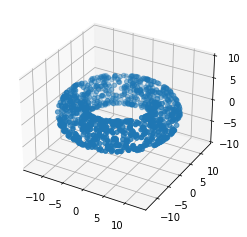

In [2]:
from pecan import data
import matplotlib.pyplot as plt
X = data.torus(1000,inner_radius=3,outer_radius=10) # make a 500 point torus
# visualize
fig = plt.figure()
ax = plt.subplot(projection='3d')
ax.set_zlim(-10,10)
ax.scatter(X[:,0],X[:,1],X[:,2])

# 1. Proof of Concept
## Is there any noticeable change in the random walk return probabilities as we power the diffusion operator?
First, let's compute the diffusion operator, eigendecompose it for efficient powering, and store the resulting diagonals of $P^t$ in a big array.

In [3]:
# create diffusion matrix
import graphtools
G = graphtools.graphs.kNNGraph(X)

Calculating KNN search...


In [4]:
# eigendecompose P, for easier computation of the powers
import numpy as np
P_symmetric = G.diff_aff.toarray()
e, v = np.linalg.eigh(P_symmetric)
# eigendecomposition is faster with the symmetric diffusion operator, but we have to convert the evecs to P evecs by multiplying them by D^(-1/2) on the left.
D = np.sum(G.K.toarray(),axis=0)

In [5]:
diagonals_over_powers = np.empty((len(P_symmetric),50))
for t in range(1,51):
    P_symmetric_t = v @ np.diag(e)**t @ v.T
    Pt = np.diag(D**(-t/2)) @ P_symmetric_t @ np.diag(D**(t/2))
    diagonals_over_powers[:,t-1] = np.diagonal(Pt)

In [6]:
diagonals_over_powers

array([[0.18181818, 0.17361023, 0.12387492, ..., 0.01110643, 0.01084607,
        0.01059777],
       [0.16666667, 0.16794872, 0.11966798, ..., 0.01597755, 0.01569223,
        0.01541612],
       [0.16666667, 0.16149961, 0.11522106, ..., 0.01444971, 0.0142416 ,
        0.01404247],
       ...,
       [0.18181818, 0.16934934, 0.12383957, ..., 0.01286614, 0.01265068,
        0.01244163],
       [0.15384615, 0.15789339, 0.11442222, ..., 0.01924804, 0.0188255 ,
        0.01841733],
       [0.18181818, 0.1609209 , 0.1355651 , ..., 0.01355699, 0.01328289,
        0.01301906]])

## First visualizations

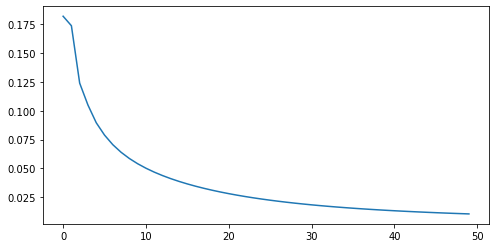

In [7]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, figsize=(8,4))
ax.plot(diagonals_over_powers[0])

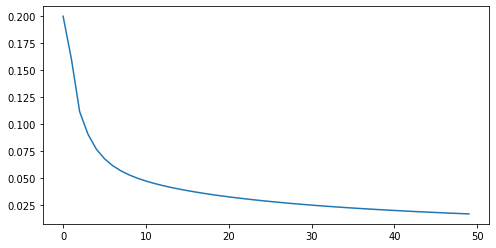

In [8]:
fig, ax = plt.subplots(1, figsize=(8,4))
ax.plot(diagonals_over_powers[5])

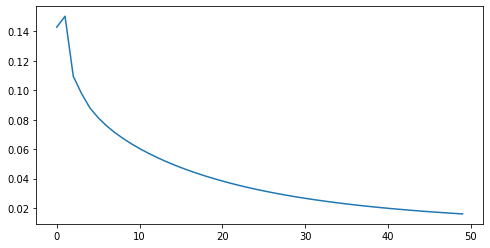

In [9]:
fig, ax = plt.subplots(1, figsize=(8,4))
ax.plot(diagonals_over_powers[16])

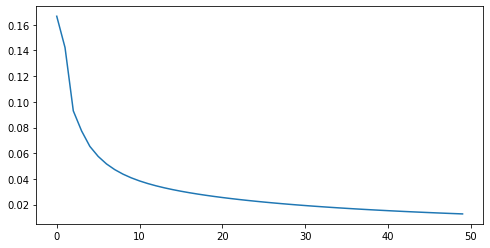

In [10]:
fig, ax = plt.subplots(1, figsize=(8,4))
ax.plot(diagonals_over_powers[30])

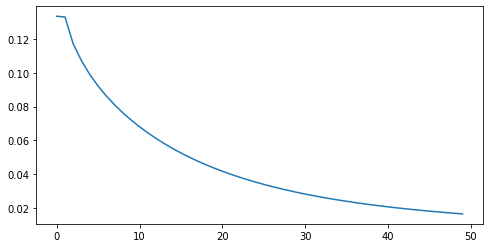

In [11]:
fig, ax = plt.subplots(1, figsize=(8,4))
ax.plot(diagonals_over_powers[309])

In [12]:
diagonals_over_powers[0]

array([0.18181818, 0.17361023, 0.12387492, 0.10487669, 0.08957157,
       0.07887071, 0.0705608 , 0.0639863 , 0.05859676, 0.05407178,
       0.0501914 , 0.04680825, 0.04381918, 0.04115056, 0.03874825,
       0.03657141, 0.03458844, 0.03277428, 0.03110862, 0.02957469,
       0.02815841, 0.0268478 , 0.02563253, 0.02450361, 0.02345317,
       0.02247426, 0.02156069, 0.02070696, 0.01990814, 0.01915978,
       0.01845789, 0.01779885, 0.01717939, 0.01659651, 0.01604752,
       0.01552994, 0.0150415 , 0.01458016, 0.014144  , 0.01373129,
       0.01334044, 0.01296998, 0.01261855, 0.01228491, 0.0119679 ,
       0.01166646, 0.01137961, 0.01110643, 0.01084607, 0.01059777])

As expected, the return probabilities decay as the neighborhood of possible destinations increases. Something interesting appears to happen around the elbow of this curve, in which the slope regime changes from steeply decreasing to less steeply decreasing. This inflection point appears pretty consistently across the plots, and may correspond to the entry of a new loop. However, it is also possible that the varying rates of decrease are simply caused by the varying area covered by increasing diffusion. Indeed, this looks like a negative exponential.

## Second visualizations, with more t's

In [191]:
diagonals_over_powers = np.empty((len(P_symmetric),100))
for t in range(1,100+1):
    P_symmetric_t = v @ np.diag(e)**t @ v.T
    Pt = np.diag(D**(-1/2)) @ P_symmetric_t @ np.diag(D**(1/2))
    diagonals_over_powers[:,t-1] = np.diagonal(Pt)

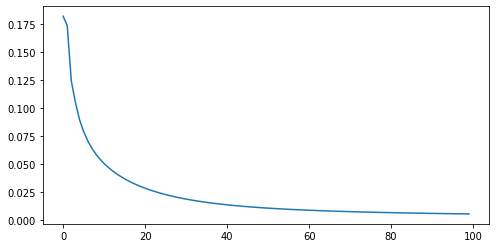

In [192]:
fig, ax = plt.subplots(1, figsize=(8,4))
ax.plot(diagonals_over_powers[0])

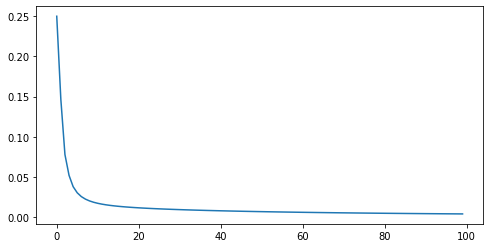

In [193]:
fig, ax = plt.subplots(1, figsize=(8,4))
ax.plot(diagonals_over_powers[100])

# 2. Correcting for the Diffusion Area
In this chapter we attempt to correct for the decrease in probabilities occasions by an increase in diffusion radius. We use the number of points diffused to as a proxy for the area covered by a t step heat kernel. We then compare the probabilities given by the diffusion operator with the expected probability within this area of heat diffusion.

In [187]:
diagonals_over_powers = np.empty((len(P_symmetric),100))
for t in range(1,100+1):
    P_symmetric_t = v @ np.diag(e)**t @ v.T
    Pt = np.diag(D**(-1/2)) @ P_symmetric_t @ np.diag(D**(1/2))
    # estimate the number of nodes the heat from each node has spread with a threshold
#     print(Pt[0])
    thresholded_Pt = (Pt>0.01).astype(int)
#     print(thresholded_Pt)
    # find the number of points which survive the threshold
    number_covered = thresholded_Pt.sum(axis=1)
    print(number_covered)
    diagonals_over_powers[:,t-1] = np.diagonal(Pt)*number_covered

[ 6  6  6  7  7  6  6  8  6  6  7  6  6  6  8  7  8  6  7  9  8  7  8  6
  7  6 10  9  6  6  8  6  6  6  8  7  7  7  6  6  7  6  7  7  8  6  7  6
  7  9  6  8  8  7  7  7  8  6  9  8 10  7  6  8  8  9  9 10  8  6  6  6
  7  6  7  7  7  6  6  7 10  8  6  6  7  7  8  8  7  7  7  6 10  6  7  6
  6  6  7 10  6  7  6  6  6  7  6  8  8  7  8  6  7  6  7  6  7  8  8  9
  6  6  6  6  7  9  7  9  7  8  8  7  7  7  7  6  8  9  8  6  6  6  6  8
  6  6  8  9  6  8  9  7  6  6  6  7  6  7  6  8  6  9  6  6  6  6  6  7
  7 10  7  8  6  6  8  8  6  6  7  7  8  6  6  6  7  8  6  7  8 10  6  6
  8  6  6  9  6  7  6  6  7  7  9  6  6  6  6  8  8  6  7  6  7  8  7  7
  8  7  8  6  7 10  8  7  7  6  7  7 10  7  7  6  7  6  6 10  6  6  6  6
  6 11  8  9  8  6  7  6  8  8  6  6  6  6  6  7  7  7  7  7  6  8  6  7
  6  6  7  6  7  6  6  6  7  6  6  7  6  6  7  8  6  6  6  6  9  9  8  8
  8  7  6  7  7  7  6  6  6  7  6  7  7  7  7 10  6  6  7  8  6  9  7  7
  7  7  8  6  8  6  6  7  7  8  9  7  6  8  7  6  9

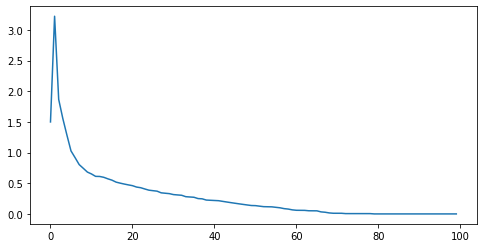

In [188]:
fig, ax = plt.subplots(1, figsize=(8,4))
ax.plot(diagonals_over_powers[100])

In [18]:
diagonals_over_powers[100]

array([1.5       , 3.37020271, 2.33481964, 1.81759206, 1.55228842,
       1.48135541, 1.32550795, 1.36293881, 1.38736594, 1.45676003,
       1.49192419, 1.53106454, 1.57281274, 1.77636579, 1.84192221,
       1.85293602, 2.03512894, 2.24608192, 2.41038196, 2.5676596 ,
       2.66090497, 2.72863123, 2.83830771, 2.98688662, 3.07748627,
       3.1240474 , 3.22953668, 3.29201858, 3.34287752, 3.3638199 ,
       3.39355483, 3.44974565, 3.50410393, 3.60059717, 3.71111921,
       3.8264437 , 3.90458778, 3.92273139, 3.96449291, 4.02872638,
       4.08306957, 4.13566131, 4.17897909, 4.20595289, 4.18049358,
       4.20642224, 4.21717723, 4.29090172, 4.2859953 , 4.33587605,
       4.3842324 , 4.43111709, 4.47000724, 4.52067216, 4.51223539,
       4.53543911, 4.60152613, 4.61036105, 4.60665348, 4.6148786 ,
       4.62866533, 4.64780769, 4.66054426, 4.6328309 , 4.6169164 ,
       4.6235395 , 4.60781493, 4.60320948, 4.59857193, 4.57261289,
       4.55237382, 4.55848119, 4.5437465 , 4.51395068, 4.48469

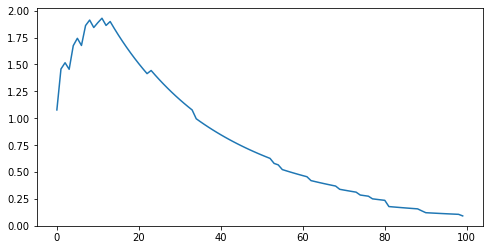

In [189]:
fig, ax = plt.subplots(1, figsize=(8,4))
ax.plot(diagonals_over_powers[10])

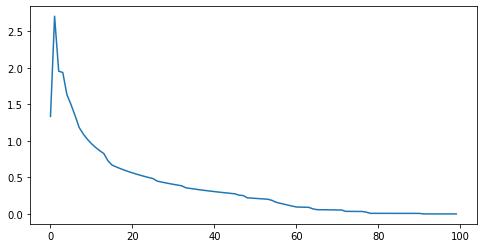

In [190]:
fig, ax = plt.subplots(1, figsize=(8,4))
ax.plot(diagonals_over_powers[30])

In [21]:
diagonals_over_powers[30]

array([1.33333333, 2.70363525, 1.95259131, 1.77927987, 1.50203664,
       1.26601158, 1.18909098, 1.03938927, 1.04890477, 1.02055936,
       0.96047342, 0.98209318, 1.00346057, 0.9582545 , 0.98125378,
       1.03359689, 1.0825691 , 1.07201803, 1.11695319, 1.05370881,
       1.02007971, 0.96382324, 0.95884574, 0.9540838 , 0.9720987 ,
       0.94503446, 0.9193057 , 0.93642232, 1.01329444, 1.02683245,
       1.09726939, 1.12650311, 1.11749242, 1.16236898, 1.18749048,
       1.19420168, 1.16707241, 1.1898684 , 1.17960137, 1.20079358,
       1.22091137, 1.19519635, 1.24353609, 1.27541489, 1.2637314 ,
       1.2523635 , 1.24130038, 1.29668955, 1.2719656 , 1.29898784,
       1.28739531, 1.30065617, 1.32538335, 1.36096596, 1.38357792,
       1.38246522, 1.38130454, 1.39114391, 1.38972487, 1.42032097,
       1.40783849, 1.45772659, 1.4856383 , 1.50261501, 1.48943398,
       1.48632529, 1.473704  , 1.48970894, 1.49593053, 1.49279282,
       1.52583984, 1.54014417, 1.54526325, 1.54157501, 1.55507

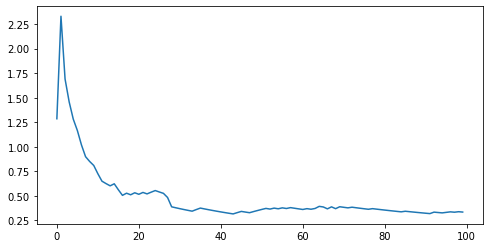

In [22]:
fig, ax = plt.subplots(1, figsize=(8,4))
ax.plot(diagonals_over_powers[370])

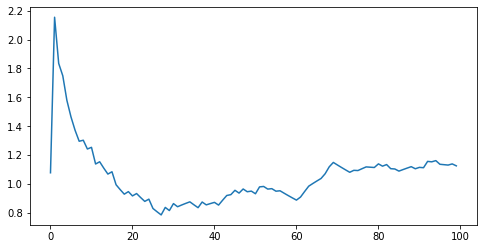

In [23]:
fig, ax = plt.subplots(1, figsize=(8,4))
ax.plot(diagonals_over_powers[375])

In [24]:
diagonals_over_powers[375]

array([1.07692308, 2.15502959, 1.8350416 , 1.74910564, 1.57886588,
       1.46404525, 1.37145561, 1.29545756, 1.30253655, 1.24176626,
       1.25326615, 1.13785392, 1.15320959, 1.10901497, 1.06798026,
       1.0839118 , 0.993912  , 0.96031267, 0.9287044 , 0.94621546,
       0.91658492, 0.93297394, 0.90507096, 0.87858566, 0.89404992,
       0.82945202, 0.80662155, 0.78484184, 0.83680803, 0.81503019,
       0.86325097, 0.84155586, 0.85358891, 0.86486983, 0.87544463,
       0.85482639, 0.83500029, 0.87420306, 0.85452194, 0.86341176,
       0.87176466, 0.85295586, 0.88697814, 0.9194331 , 0.92539149,
       0.95546229, 0.93616941, 0.96455543, 0.9455627 , 0.94978595,
       0.93153651, 0.97912667, 0.98210787, 0.96389803, 0.96680242,
       0.94928572, 0.95211661, 0.93525194, 0.91886965, 0.9029511 ,
       0.88747858, 0.90878673, 0.94715981, 0.98416837, 1.00258324,
       1.02030596, 1.03736565, 1.0702555 , 1.11822392, 1.14865113,
       1.1309236 , 1.11364396, 1.09679708, 1.08036849, 1.09390

## With more sophisticated plots
Which shall show both the normalized return probabilities, and the location of the point in question on the torus.

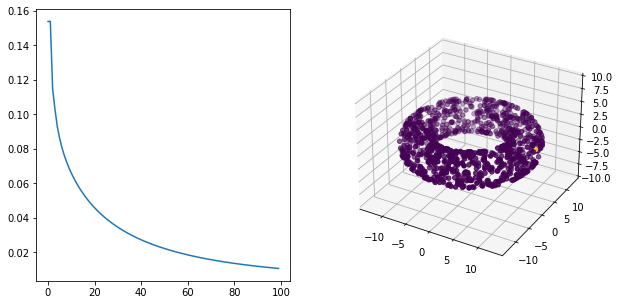

In [194]:
point = 375
c = np.zeros(len(X))
c[point] = 1
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1,2,1)
ax1.plot(diagonals_over_powers[point])
ax2 = fig.add_subplot(1,2,2,projection='3d')
ax2.set_zlim(-10,10)
ax2.scatter(X[:,0],X[:,1],X[:,2],c=c)

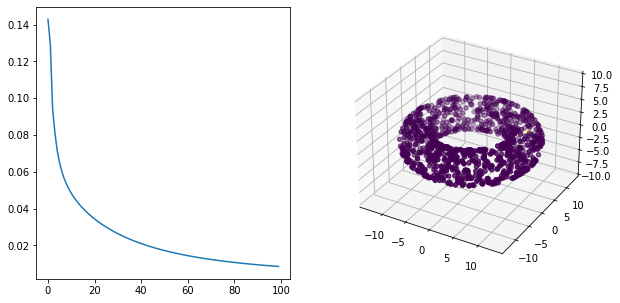

In [195]:
point = 370
c = np.zeros(len(X))
c[point] = 1
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1,2,1)
ax1.plot(diagonals_over_powers[point])
ax2 = fig.add_subplot(1,2,2,projection='3d')
ax2.set_zlim(-10,10)
ax2.scatter(X[:,0],X[:,1],X[:,2],c=c)

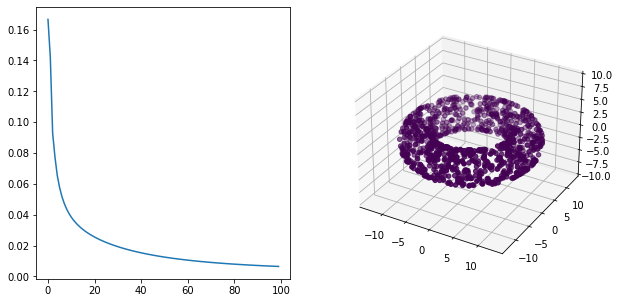

In [196]:
point = 30
c = np.zeros(len(X))
c[point] = 1
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1,2,1)
ax1.plot(diagonals_over_powers[point])
ax2 = fig.add_subplot(1,2,2,projection='3d')
ax2.set_zlim(-10,10)
ax2.scatter(X[:,0],X[:,1],X[:,2],c=c)

# Correcting for the total number of random walks

The diagonals of the diffusion matrix represent $\frac{\text{#return walks}}{\text{#total walks}}$. To isolate the number of return walks, we here try to multiply by the total number of random walks.

In [184]:
diagonals_over_powers = np.empty((len(P_symmetric),100))
number_of_total_walks_collected = np.empty((len(P_symmetric),100))
diagonals_collected = np.empty((len(P_symmetric),100))

Pts = []
nums_walks = []
for t in range(1,100+1):
    P_symmetric_t = v @ np.diag(e)**t @ v.T
    Pt = np.diag(D**(-1/2)) @ P_symmetric_t @ np.diag(D**(1/2))
    # estimate the total number of random walks as one over the smallest probability
    smallest_walk_probability = np.min(Pt,axis=1)
    number_of_total_walks = smallest_walk_probability
    Pts.append(Pt)
#     print(np.diagonal(Pt)[20:40])
#     print(number_of_total_walks)
    diagonals_collected[:,t-1] = np.diagonal(Pt)
    number_of_total_walks_collected[:,t-1] = smallest_walk_probability
    diagonals_over_powers[:,t-1] = np.diagonal(Pt) / number_of_total_walks

Text(0, 0.5, 'return probability * #walks')

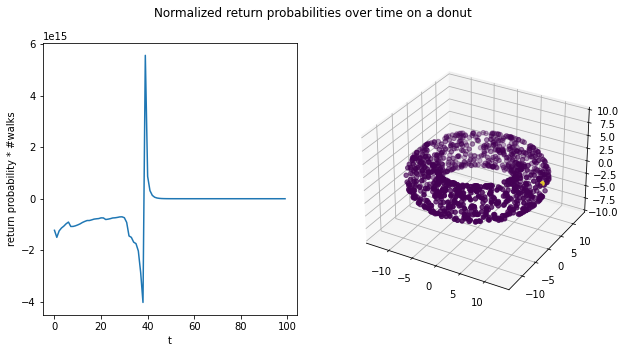

In [180]:
point = 375
c = np.zeros(len(X))
c[point] = 1
# diffuse colors
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1,2,1)
ax1.plot(diagonals_over_powers[point])
ax2 = fig.add_subplot(1,2,2,projection='3d')
ax2.set_zlim(-10,10)
ax2.scatter(X[:,0],X[:,1],X[:,2],c=c)
fig.suptitle("Normalized return probabilities over time on a donut")
ax1.set_xlabel("t")
ax1.set_ylabel("return probability * #walks")

Text(0, 0.5, 'return probability * #walks')

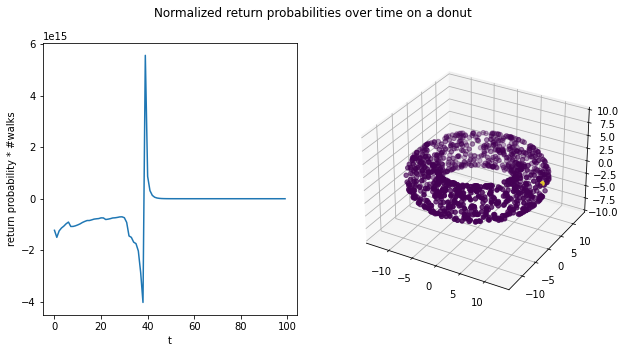

In [180]:
point = 375
c = np.zeros(len(X))
c[point] = 1
# diffuse colors
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1,2,1)
ax1.plot(diagonals_over_powers[point])
ax2 = fig.add_subplot(1,2,2,projection='3d')
ax2.set_zlim(-10,10)
ax2.scatter(X[:,0],X[:,1],X[:,2],c=c)
fig.suptitle("Normalized return probabilities over time on a donut")
ax1.set_xlabel("t")
ax1.set_ylabel("return probability * #walks")

Text(0, 0.5, 'return probability * #walks')

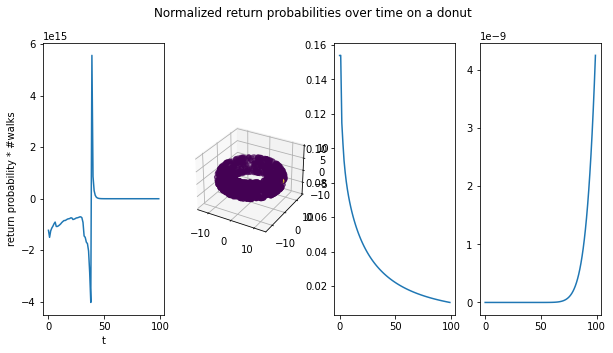

In [185]:
point = 375
c = np.zeros(len(X))
c[point] = 1
# diffuse colors
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1,4,1)
ax1.plot(diagonals_over_powers[point])
ax2 = fig.add_subplot(1,4,2,projection='3d')
ax2.set_zlim(-10,10)
ax2.scatter(X[:,0],X[:,1],X[:,2],c=c)
ax3 = fig.add_subplot(1,4,3)
ax3.plot(diagonals_collected[point])
ax4 = fig.add_subplot(1,4,4)
ax4.plot(number_of_total_walks_collected[point])


fig.suptitle("Normalized return probabilities over time on a donut")
ax1.set_xlabel("t")
ax1.set_ylabel("return probability * #walks")

In [186]:
number_of_total_walks_collected[point]

array([-1.25520964e-16, -1.02708440e-16, -9.18527814e-17, -9.04991096e-17,
       -8.73153440e-17, -8.85973766e-17, -8.90210583e-17, -7.07953845e-17,
       -6.73216708e-17, -6.56502715e-17, -6.49229719e-17, -6.48344989e-17,
       -6.58822826e-17, -6.62852491e-17, -6.64563711e-17, -6.41317959e-17,
       -6.37930402e-17, -6.38930303e-17, -6.27370470e-17, -6.14574933e-17,
       -6.17288081e-17, -5.96376520e-17, -5.34391187e-17, -5.27596649e-17,
       -5.25784582e-17, -5.29297375e-17, -5.19349388e-17, -5.15355582e-17,
       -5.15366110e-17, -5.04943662e-17, -4.68891111e-17, -3.66372830e-17,
       -2.27306305e-17, -2.13703261e-17, -1.85536756e-17, -1.75224328e-17,
       -1.47175233e-17, -1.02010214e-17, -7.07710494e-18,  5.00584416e-18,
        3.14640602e-17,  8.51388677e-17,  1.99722292e-16,  4.34519950e-16,
        8.72133873e-16,  1.68908536e-15,  3.16277346e-15,  5.73396948e-15,
        1.00887286e-14,  1.72655608e-14,  2.88040082e-14,  4.69365242e-14,
        7.48389897e-14,  

Text(0, 0.5, 'return probability * #walks')

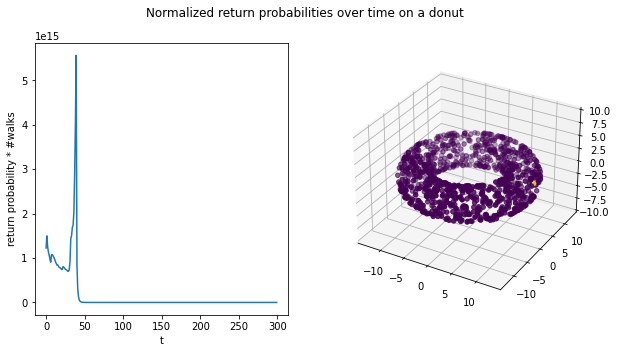

In [168]:
point = 375
c = np.zeros(len(X))
c[point] = 1
# diffuse colors

fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1,2,1)
ax1.plot(diagonals_over_powers[point])
ax2 = fig.add_subplot(1,2,2,projection='3d')
ax2.set_zlim(-10,10)
ax2.scatter(X[:,0],X[:,1],X[:,2],c=c)
fig.suptitle("Normalized return probabilities over time on a donut")
ax1.set_xlabel("t")
ax1.set_ylabel("return probability * #walks")

In [31]:
diagonals_over_powers[375][10:50]

array([4.70413376e+14, 3.98951146e+14, 3.43257382e+14, 2.94842100e+14,
       2.50512520e+14, 2.15568589e+14, 1.90823848e+14, 1.63920922e+14,
       1.42267526e+14, 1.23496097e+14, 1.06435594e+14, 9.56894695e+13,
       8.21601292e+13, 7.28167915e+13, 6.39752034e+13, 5.56755295e+13,
       4.97387319e+13, 4.39613843e+13, 3.85753008e+13, 3.45654166e+13,
       3.26945687e+13, 3.67690079e+13, 1.66017810e+15, 1.60898847e+15,
       1.33690685e+15, 1.21031188e+15, 1.35825216e+15, 2.80371973e+15,
       1.84173163e+16, 1.37196410e+18, 8.84520720e+17, 5.00690094e+17,
       2.81124176e+17, 1.59505636e+17, 9.35317728e+16, 5.68546922e+16,
       3.57553587e+16, 2.32304576e+16, 1.55557252e+16, 1.07118975e+16])

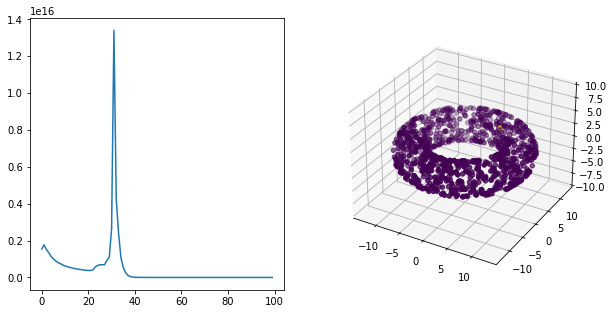

In [128]:
point = 90
c = np.zeros(len(X))
c[point] = 1
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1,2,1)
ax1.plot(diagonals_over_powers[point])
ax2 = fig.add_subplot(1,2,2,projection='3d')
ax2.set_zlim(-10,10)
ax2.scatter(X[:,0],X[:,1],X[:,2],c=c)

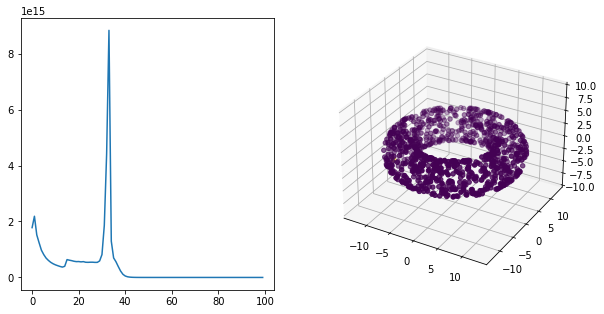

In [129]:
point = 400
c = np.zeros(len(X))
c[point] = 1
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1,2,1)
ax1.plot(diagonals_over_powers[point])
ax2 = fig.add_subplot(1,2,2,projection='3d')
ax2.set_zlim(-10,10)
ax2.scatter(X[:,0],X[:,1],X[:,2],c=c)

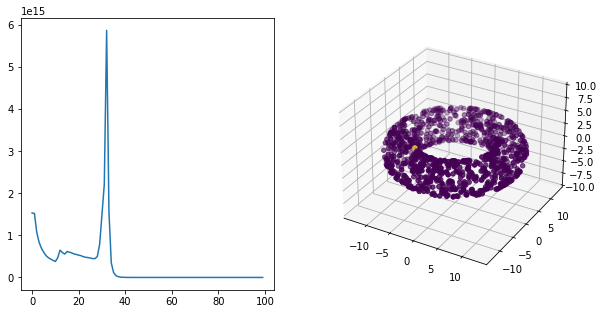

In [130]:
point = 5
c = np.zeros(len(X))
c[point] = 1
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1,2,1)
ax1.plot(diagonals_over_powers[point])
ax2 = fig.add_subplot(1,2,2,projection='3d')
ax2.set_zlim(-10,10)
ax2.scatter(X[:,0],X[:,1],X[:,2],c=c)

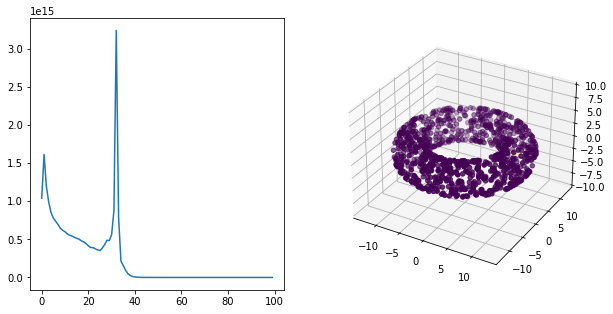

In [131]:
point = 59
c = np.zeros(len(X))
c[point] = 1
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1,2,1)
ax1.plot(diagonals_over_powers[point])
ax2 = fig.add_subplot(1,2,2,projection='3d')
ax2.set_zlim(-10,10)
ax2.scatter(X[:,0],X[:,1],X[:,2],c=c)

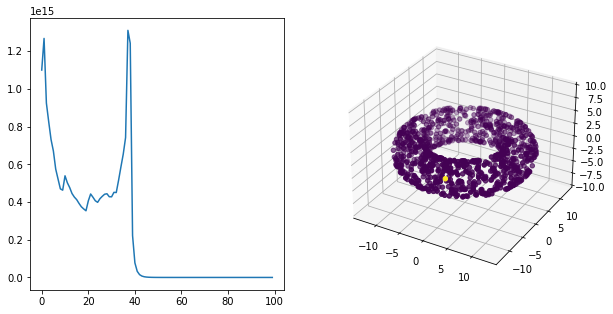

In [132]:
point = 42
c = np.zeros(len(X))
c[point] = 1
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1,2,1)
ax1.plot(diagonals_over_powers[point])
ax2 = fig.add_subplot(1,2,2,projection='3d')
ax2.set_zlim(-10,10)
ax2.scatter(X[:,0],X[:,1],X[:,2],c=c)

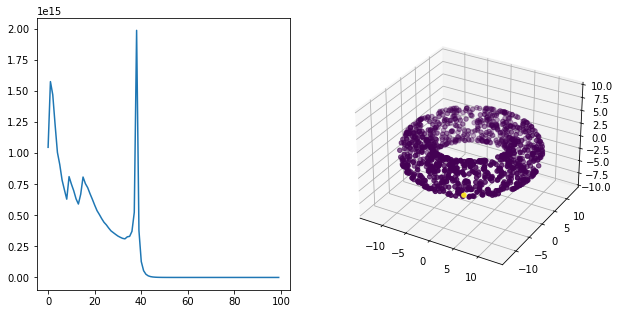

In [133]:
point = 402
c = np.zeros(len(X))
c[point] = 1
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1,2,1)
ax1.plot(diagonals_over_powers[point])
ax2 = fig.add_subplot(1,2,2,projection='3d')
ax2.set_zlim(-10,10)
ax2.scatter(X[:,0],X[:,1],X[:,2],c=c)

In [38]:
o = np.random.rand(4,4)
np.min(o,axis=1)

array([0.3132766 , 0.06196929, 0.26985014, 0.38010766])

In [39]:
o = np.random.rand(4,4)
np.min(o,axis=1)

array([0.20130552, 0.34340242, 0.1288347 , 0.27696318])

In [40]:
o

array([[0.56191102, 0.20130552, 0.88426208, 0.35719951],
       [0.37488472, 0.56838115, 0.35757472, 0.34340242],
       [0.43810919, 0.46483835, 0.1288347 , 0.5229337 ],
       [0.84606001, 0.5895181 , 0.27696318, 0.3234729 ]])

# How far does the diffusion actually travel?

In [158]:
np.allclose(Pts[0],G.P.toarray())

True

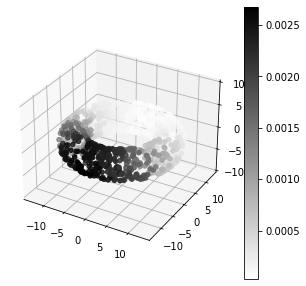

In [166]:
# diffuse the color
point = 48
t = 299
c = np.zeros(len(X))
c[point]=1
c = Pts[t] @ c



fig = plt.figure(figsize=(5,5))
ax = plt.subplot(projection='3d')
ax.set_zlim(-10,10)
p = ax.scatter(X[:,0],X[:,1],X[:,2],c=c, cmap=plt.cm.get_cmap('binary'))
# ax.colorbar(ticks=range(6), label='digit value')
# ax.clim(-0.5, 5.5)
fig.colorbar(p, ax=ax)

ImportError: cannot import name 'asdfaf' from 'pecan' (/Users/adjourner/models/PECAN/pecan/__init__.py)

In [ ]:
diagonals_over_powers = np.empty((len(P_symmetric),300))
Pts = []
for t in range(1,300+1):
    P_symmetric_t = v @ np.diag(e)**t @ v.T
    Pt = np.diag(D**(-1/2)) @ P_symmetric_t @ np.diag(D**(1/2))
    # estimate the total number of random walks as one over the smallest probability
    smallest_walk_probability = np.min(Pt,axis=1)
    number_of_total_walks = 1/np.abs(smallest_walk_probability)
    Pts.append(Pt)
    print(np.diagonal(Pt)[20:40])
    print(number_of_total_walks)
    diagonals_over_powers[:,t-1] = np.diagonal(Pt) * number_of_total_walks

[0.16666667 0.16666667 0.14285714 0.18181818 0.15384615 0.16666667
 0.125      0.15384615 0.18181818 0.18181818 0.16666667 0.16666667
 0.22222222 0.2        0.15384615 0.15384615 0.18181818 0.16666667
 0.18181818 0.16666667]
[2.88230376e+15 7.08127171e+15 7.54344807e+15 9.56769900e+15
 8.82842263e+15 7.67241350e+15 6.70303200e+15 1.02007294e+16
 6.50478038e+15 5.72535168e+15 9.06446071e+15 8.77896487e+15
 7.04125156e+15 9.14270109e+15 8.95473013e+15 6.02394914e+15
 7.08192008e+15 8.06770943e+15 7.80097740e+15 5.57774129e+15
 9.65914665e+15 5.18028745e+15 1.39907740e+16 6.39839237e+15
 8.06017888e+15 9.41400565e+15 1.22589742e+16 5.12129861e+15
 4.34325044e+15 9.61950590e+15 9.15755173e+15 7.81939765e+15
 7.84102811e+15 7.14749423e+15 9.79794875e+15 5.19163928e+15
 7.26209409e+15 7.36136484e+15 7.17943611e+15 8.02554814e+15
 9.16124733e+15 6.24184600e+15 6.05208139e+15 7.63744406e+15
 1.07511480e+16 5.94344539e+15 6.13295998e+15 5.18370568e+15
 8.29044570e+15 8.18416145e+15 3.61601159e+

In [42]:
point = 402
c = np.zeros(len(X))
c[point] = 1
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1,2,1)
ax1.plot(diagonals_over_powers[point])
ax2 = fig.add_subplot(1,2,2,projection='3d')
ax2.set_zlim(-10,10)
ax2.scatter(X[:,0],X[:,1],X[:,2],c=c)

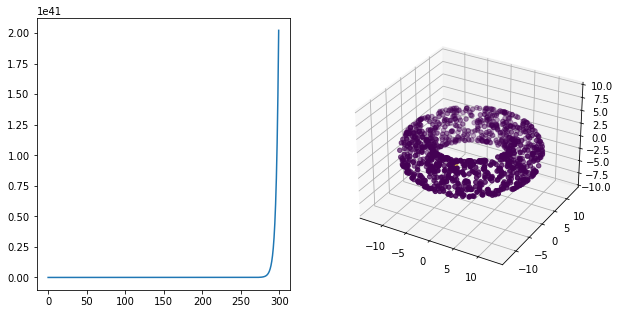

In [142]:
point = 87
c = np.zeros(len(X))
c[point] = 1
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1,2,1)
ax1.plot(diagonals_over_powers[point])
ax2 = fig.add_subplot(1,2,2,projection='3d')
ax2.set_zlim(-10,10)
ax2.scatter(X[:,0],X[:,1],X[:,2],c=c)